In [1]:
from riskeye.utils.data import get_all_behavior, get_all_eyepos_info, get_all_subjects, Subject
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = get_all_behavior()

In [3]:
summarized_fixations = get_all_eyepos_info(source='eyepos', summarize=True)
summarized_fixations = summarized_fixations.join(df)
summarized_fixations['Experiment'] = summarized_fixations.index.get_level_values('exptype').map({'symbolic':'Symbols', 'non-symbolic':'Coin clouds'})

In [4]:
summarized_fixations.reset_index().groupby(['subject'])['n_saccades'].mean().sort_values()

subject
58    0.033333
53    1.320833
05    1.514286
54    1.531250
59    1.554167
        ...   
51    4.156118
49    4.194384
44    4.312500
17    4.406250
43    4.539583
Name: n_saccades, Length: 63, dtype: float64

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_75903/2490577334.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  p = sns.histplot(data=summarized_fixations.reset_index(), x='n_saccades', hue='Experiment', bins=np.arange(.5, 9.5, 1), multiple="dodge", shrink=.85, stat='percent', palette=sns.color_palette()[-3:])


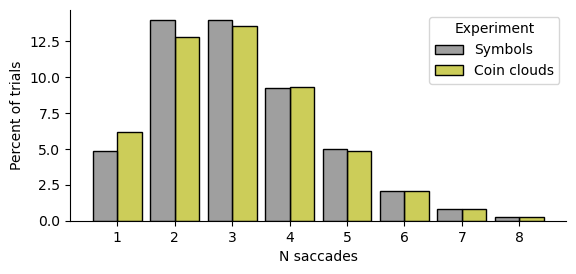

In [5]:
summarized_fixations
p = sns.histplot(data=summarized_fixations.reset_index(), x='n_saccades', hue='Experiment', bins=np.arange(.5, 9.5, 1), multiple="dodge", shrink=.85, stat='percent', palette=sns.color_palette()[-3:])
p.set_ylabel('Percent of trials')
p.set_xlabel('N saccades')

p.set_aspect(1/4.)
sns.despine()


In [29]:
def merge_fixations(d):
    d['previous_fixation_target'] = d['fixation_target'].shift(1)

    result = []

    n = 1
    duration = 0.0

    for ix, row in d.iterrows():
        if (row.fixation_target == row['previous_fixation_target']) or (pd.isnull(row.previous_fixation_target)):
            duration += row.duration
        else:
            result.append({'duration':duration, 'fixation_target':row.previous_fixation_target})
            duration = row.duration
            n += 1

    if duration != 0:
        result.append({'duration':duration, 'fixation_target':row.fixation_target})

    return pd.DataFrame(result, index=pd.Index(np.arange(1, n+1), name='n'))



In [30]:
fixations = fixations[np.in1d(fixations['fixation_target'], ['left_option', 'right_option'])].droplevel('n')

fixations = fixations.groupby(['subject', 'run', 'block', 'trial']).apply(merge_fixations)
# saccades['n'] = saccades.groupby(['subject', 'run', 'block', 'trial']).cumcount() + 1

In [31]:
df['EV_left'] = df['p_left'] * df['n_left']
df['EV_right'] = df['p_right'] * df['n_right']
fixations = fixations.join(df[['EV_left', 'EV_right', 'n_safe', 'n_risky', 'n_left', 'n_right', 'chose_risky', 'EV_left', 'EV_right', 'n_safe', 'n_risky', 'n_left', 'n_right', 'log(risky/safe)']])
fixations = fixations.join((df['p_left'] == 0.55).to_frame('risky_left'))

fixations['risky_left'] = fixations['risky_left'].astype(bool)
fixations['chose_risky'] = fixations['chose_risky'].astype(bool)

fixations['risky_fixation'] = ((fixations['fixation_target'] == 'left_option') & fixations['risky_left']) | ((fixations['fixation_target'] == 'right_option') & ~fixations['risky_left'])
fixations['left_fixation'] = (fixations['fixation_target'] == 'left_option')

fixations['safe_fixation'] = ~fixations['risky_fixation'] 
fixations['chosen_fixation'] = (fixations['chose_risky']  & fixations['risky_fixation']) | (~fixations['chose_risky'] & fixations['safe_fixation'])

In [32]:
last_fixations = fixations.groupby(['subject', 'exptype', 'run', 'block', 'trial']).apply(lambda d: d.reset_index('n').iloc[-1])
last_fixations['n'] = 'last'
last_fixations.set_index('n', append=True, inplace=True)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_5381/1277067086.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = fixations.groupby(['subject', 'exptype', 'n']).mean()
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_5381/1277067086.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = pd.concat((tmp.query('n < 4'), last_fixations.groupby(['subject', 'exptype', 'n']).mean()))


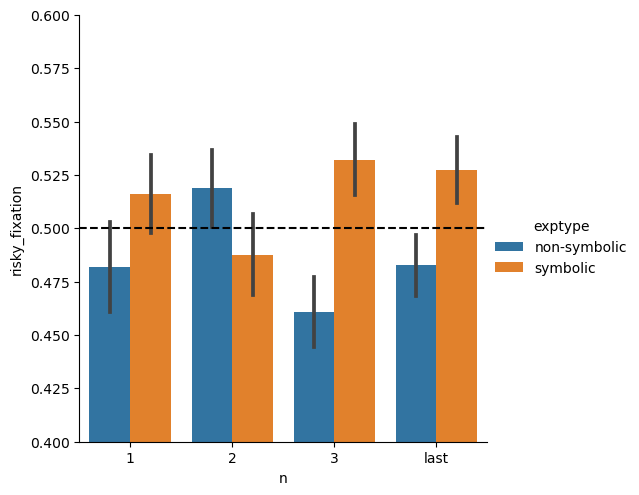

In [33]:
tmp = fixations.groupby(['subject', 'exptype', 'n']).mean()
tmp = pd.concat((tmp.query('n < 4'), last_fixations.groupby(['subject', 'exptype', 'n']).mean()))
sns.catplot(data=tmp.reset_index(), x='n', y='risky_fixation', hue='exptype', kind='bar', errorbar='se')
plt.ylim(.4, .6)
plt.axhline(0.5, c='k', ls='--')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_5381/680412679.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = fixations.groupby(['subject', 'exptype', 'n']).mean()
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_5381/680412679.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = pd.concat((tmp.query('n < 4'), last_fixations.groupby(['subject', 'exptype', 'n']).mean()))


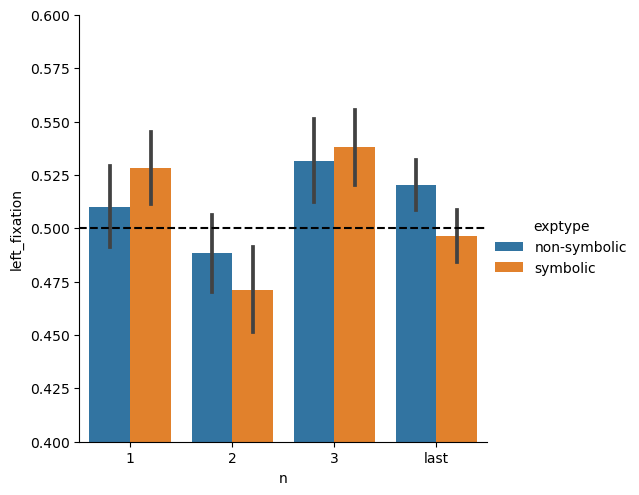

In [34]:
tmp = fixations.groupby(['subject', 'exptype', 'n']).mean()
tmp = pd.concat((tmp.query('n < 4'), last_fixations.groupby(['subject', 'exptype', 'n']).mean()))
sns.catplot(data=tmp.reset_index(), x='n', y='left_fixation', hue='exptype', kind='bar', errorbar='se')
plt.ylim(.4, .6)
plt.axhline(0.5, c='k', ls='--')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_5381/1545166524.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = fixations.groupby(['subject', 'exptype', 'n']).mean()
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_5381/1545166524.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = pd.concat((tmp.query('n < 4'), last_fixations.groupby(['subject', 'exptype', 'n']).mean()))


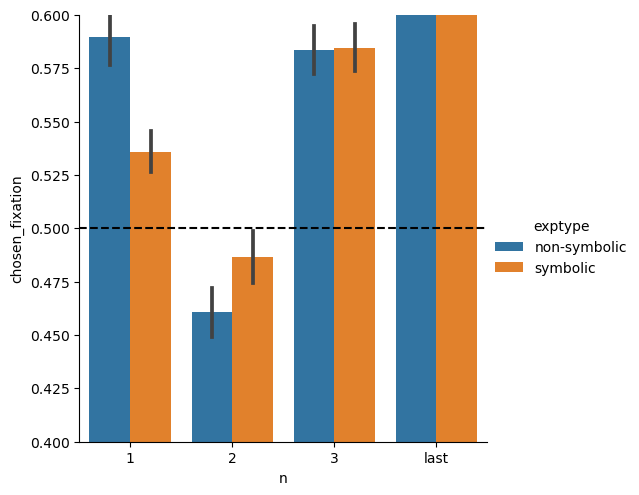

In [35]:
tmp = fixations.groupby(['subject', 'exptype', 'n']).mean()
tmp = pd.concat((tmp.query('n < 4'), last_fixations.groupby(['subject', 'exptype', 'n']).mean()))
sns.catplot(data=tmp.reset_index(), x='n', y='chosen_fixation', hue='exptype', kind='bar', errorbar='se')
plt.ylim(.4, .6)
plt.axhline(0.5, c='k', ls='--')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_5381/3393459346.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = fixations.groupby(['subject', 'exptype', 'n']).mean()


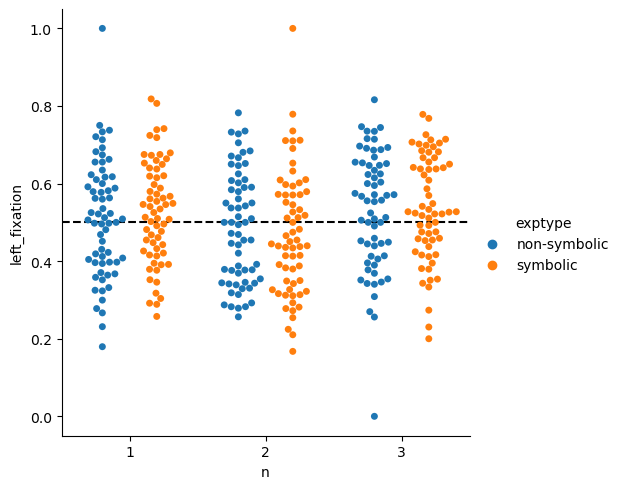

In [36]:
tmp = fixations.groupby(['subject', 'exptype', 'n']).mean()
sns.catplot(data=tmp.query('n < 4').reset_index(), x='n', y='left_fixation', hue='exptype', kind='swarm', errorbar='se', dodge=True)
# plt.ylim(.4, .6)
plt.axhline(0.5, c='k', ls='--')

In [37]:
fixations['EV_fixated'] = fixations['EV_left'].where(fixations['left_fixation'], fixations['EV_right'])
fixations['n_fixated'] = fixations['n_left'].where(fixations['left_fixation'], fixations['n_right'])

ValueError: Cannot set a DataFrame with multiple columns to the single column EV_fixated

In [ ]:
fixations['EV_risky'] = fixations['EV_left'].where(fixations['risky_left'], fixations['EV_right'])
fixations['EV_safe'] = fixations['EV_left'].where(~fixations['risky_left'], fixations['EV_right'])

ValueError: columns overlap but no suffix specified: Index(['log(risky/safe)'], dtype='object')

In [ ]:
fixations['bin(EV_fixated)'] = pd.cut(fixations['EV_fixated'], bins=np.arange(0, 120, 5))
fixations['bin(EV_fixated)'].cat.categories = [bin.mid for bin in fixations['bin(EV_fixated)'].cat.categories]

fixations['bin(EV_left)'] = pd.cut(fixations['EV_left'], bins=np.arange(0, 120, 5))
fixations['bin(EV_left)'].cat.categories = [bin.mid for bin in fixations['bin(EV_left)'].cat.categories]

fixations['bin(EV_risky)'] = pd.cut(fixations['EV_risky'], bins=np.arange(0, 120, 10))
fixations['bin(EV_risky)'].cat.categories = [bin.mid for bin in fixations['bin(EV_risky)'].cat.categories]

fixations['bin(log(risky/safe))'] = pd.qcut(fixations['log(risky/safe)'], q=7)
fixations['bin(log(risky/safe))'].cat.categories = [bin.mid for bin in fixations['bin(log(risky/safe))'].cat.categories]
# saccades['bin(EV_safe)'] = pd.cut(saccades['EV_safe'], bins=np.arange(0, 120, ))
# saccades['bin(EV_safe)'].cat.categories = [bin.mid for bin in saccades['bin(EV_safe)'].cat.categories]

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_89038/4178012155.py:2: FutureWarning: Setting categories in-place is deprecated and will raise in a future version. Use rename_categories instead.
  fixations['bin(EV_fixated)'].cat.categories = [bin.mid for bin in fixations['bin(EV_fixated)'].cat.categories]
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_89038/4178012155.py:5: FutureWarning: Setting categories in-place is deprecated and will raise in a future version. Use rename_categories instead.
  fixations['bin(EV_left)'].cat.categories = [bin.mid for bin in fixations['bin(EV_left)'].cat.categories]
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_89038/4178012155.py:8: FutureWarning: Setting categories in-place is deprecated and will raise in a future version. Use rename_categories instead.
  fixations['bin(EV_risky)'].cat.categories = [bin.mid for bin in fixations['bin(EV_risky)'].cat.categories]
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipyk

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_89038/144992073.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = fixations.groupby(['subject', 'bin(EV_risky)', 'n', 'exptype']).mean()
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_89038/144992073.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  tmp = tmp[~tmp.isnull().any(1)]
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_89038/144992073.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = fixations.groupby(['subject', 'EV_safe', 'n', 'e

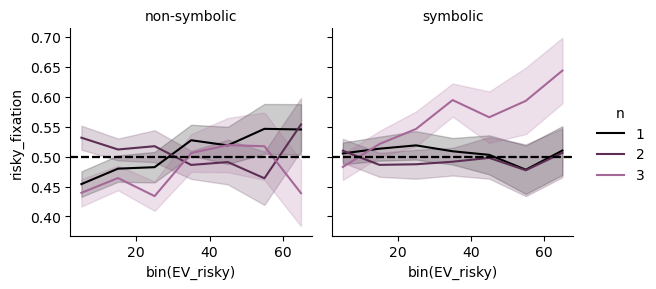

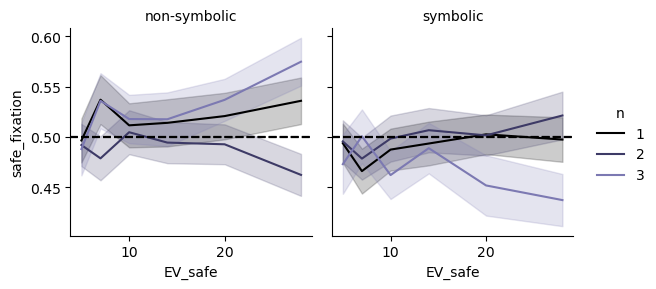

In [ ]:
tmp = fixations.groupby(['subject', 'bin(EV_risky)', 'n', 'exptype']).mean()
tmp = tmp[~tmp.isnull().any(1)]

palette = sns.cubehelix_palette(start=.5, rot=0, dark=0, light=.5, n_colors=3, reverse=True)

g = sns.FacetGrid(tmp.query('(n < 4)').reset_index(), col='exptype', hue='n', palette=palette)#, palette='coolwarm')
g.map(sns.lineplot, 'bin(EV_risky)', 'risky_fixation', errorbar='se')
g.add_legend()
g.set_titles('{col_name}')
g.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))

tmp = fixations.groupby(['subject', 'EV_safe', 'n', 'exptype']).mean()
palette = sns.cubehelix_palette(start=0, rot=0, dark=0, light=.5, n_colors=3, reverse=True)
g = sns.FacetGrid(tmp.query('(n < 4)').reset_index(), col='exptype', hue='n', palette=palette)#, palette='coolwarm')
g.map(sns.lineplot, 'EV_safe', 'safe_fixation', errorbar='se')
g.add_legend()
g.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))
g.set_titles('{col_name}')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_89038/3884017233.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = fixations.groupby(['subject', 'bin(log(risky/safe))', 'n', 'exptype']).mean()
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_89038/3884017233.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  tmp = tmp[~tmp.isnull().any(1)]


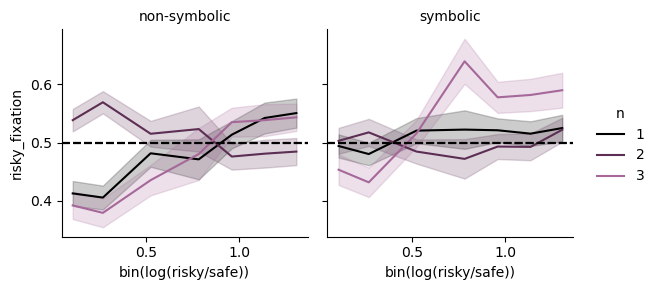

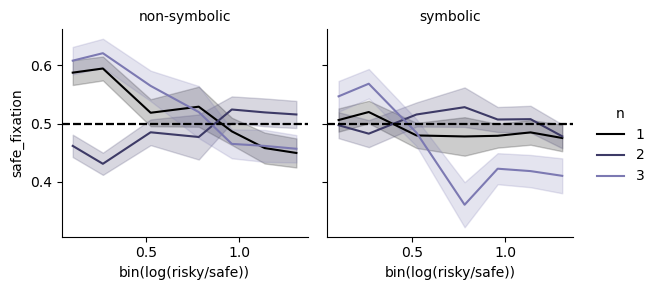

In [ ]:
tmp = fixations.groupby(['subject', 'bin(log(risky/safe))', 'n', 'exptype']).mean()
tmp = tmp[~tmp.isnull().any(1)]

palette = sns.cubehelix_palette(start=.5, rot=0, dark=0, light=.5, n_colors=3, reverse=True)

g = sns.FacetGrid(tmp.query('(n < 4)').reset_index(), col='exptype', hue='n', palette=palette)#, palette='coolwarm')
g.map(sns.lineplot, 'bin(log(risky/safe))', 'risky_fixation', errorbar='se')
g.add_legend()
g.set_titles('{col_name}')
g.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))

palette = sns.cubehelix_palette(start=0, rot=0, dark=0, light=.5, n_colors=3, reverse=True)
g = sns.FacetGrid(tmp.query('(n < 4)').reset_index(), col='exptype', hue='n', palette=palette)#, palette='coolwarm')
g.map(sns.lineplot, 'bin(log(risky/safe))', 'safe_fixation', errorbar='se')
g.add_legend()
g.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))
g.set_titles('{col_name}')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_89038/3910912719.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = last_fixations.groupby(['subject', 'bin(EV_risky)', 'exptype']).mean()
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_89038/3910912719.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  tmp = tmp[~tmp.isnull().any(1)]
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_89038/3910912719.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = last_fixations.groupby(['subject', 'EV_safe',

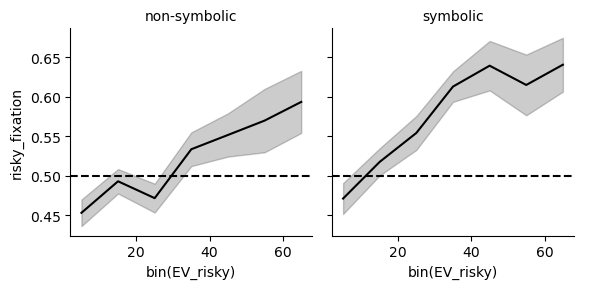

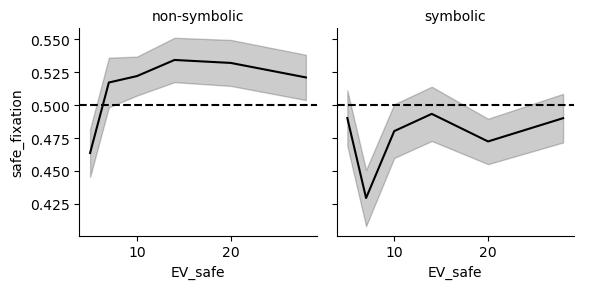

In [ ]:
tmp = last_fixations.groupby(['subject', 'bin(EV_risky)', 'exptype']).mean()
tmp = tmp[~tmp.isnull().any(1)]


g = sns.FacetGrid(tmp.reset_index(), col='exptype')#, palette='coolwarm')
g.map(sns.lineplot, 'bin(EV_risky)', 'risky_fixation', errorbar='se', color='k')
g.add_legend()
g.set_titles('{col_name}')
g.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))


tmp = last_fixations.groupby(['subject', 'EV_safe', 'exptype']).mean()
g = sns.FacetGrid(tmp.reset_index(), col='exptype')#, palette='coolwarm')
g.map(sns.lineplot, 'EV_safe', 'safe_fixation', errorbar='se', color='k')
g.add_legend()
g.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))
g.set_titles('{col_name}')

In [38]:
tmp = last_fixations.groupby(['subject', 'bin(log(risky/safe))', 'exptype']).mean()

g = sns.FacetGrid(tmp.reset_index(), col='exptype', palette=palette)#, palette='coolwarm')
g.map(sns.lineplot, 'bin(log(risky/safe))', 'risky_fixation', errorbar='se', color='k')
g.add_legend()
g.set_titles('{col_name}')
g.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))

g = sns.FacetGrid(tmp.reset_index(), col='exptype', palette=palette)#, palette='coolwarm')
g.map(sns.lineplot, 'bin(log(risky/safe))', 'safe_fixation', errorbar='se', color='k')
g.add_legend()
g.set_titles('{col_name}')
g.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))


tmp = last_fixations.groupby(['subject', 'bin(log(risky/safe))', 'exptype', 'n_safe']).mean()
g = sns.FacetGrid(tmp.reset_index(), col='exptype', hue='n_safe', palette='coolwarm')#, palette='coolwarm')
g.map(sns.lineplot, 'bin(log(risky/safe))', 'safe_fixation', errorbar='se')
g.add_legend()
g.set_titles('{col_name}')
g.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))
# tmp = last_fixations.groupby(['subject', 'EV_safe', 'exptype']).mean()
# palette = sns.cubehelix_palette(start=0, rot=0, dark=0, light=.5, n_colors=3, reverse=True)
# g = sns.FacetGrid(tmp.query('(n < 4)').reset_index(), col='exptype', palette=palette)#, palette='coolwarm')
# g.map(sns.lineplot, 'EV_safe', 'safe_fixation', errorbar='se')
# g.add_legend()
# g.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))
# g.set_titles('{col_name}')

KeyError: 'bin(log(risky/safe))'

In [ ]:
fixations['duration'].clip(0, 1000, inplace=True)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_89038/1124703105.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = fixations.groupby(['subject', 'bin(EV_risky)', 'n', 'exptype']).mean()
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_89038/1124703105.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  tmp = tmp[~tmp.isnull().any(1)]


NameError: name 'saccades' is not defined

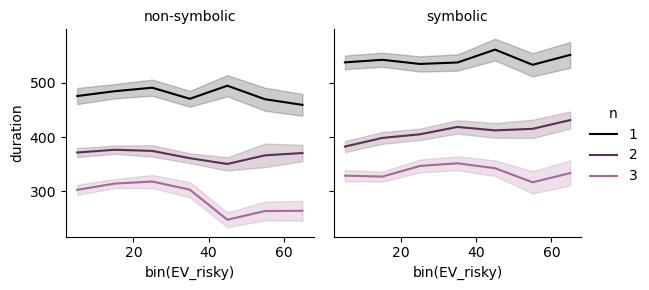

In [ ]:
tmp = fixations.groupby(['subject', 'bin(EV_risky)', 'n', 'exptype']).mean()
tmp = tmp[~tmp.isnull().any(1)]

palette = sns.cubehelix_palette(start=.5, rot=0, dark=0, light=.5, n_colors=3, reverse=True)

g = sns.FacetGrid(tmp.query('(n < 4)').reset_index(), col='exptype', hue='n', palette=palette)#, palette='coolwarm')
g.map(sns.lineplot, 'bin(EV_risky)', 'duration', errorbar='se')
g.add_legend()
g.set_titles('{col_name}')

tmp = saccades.groupby(['subject', 'EV_safe', 'n', 'exptype']).mean()
palette = sns.cubehelix_palette(start=0, rot=0, dark=0, light=.5, n_colors=3, reverse=True)
g = sns.FacetGrid(tmp.query('(n < 4)').reset_index(), col='exptype', hue='n', palette=palette)#, palette='coolwarm')
g.map(sns.lineplot, 'EV_safe', 'duration', errorbar='se')
g.add_legend()
g.set_titles('{col_name}')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_89038/2375485814.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = fixations.groupby(['subject', 'bin(log(risky/safe))', 'n', 'exptype']).mean()
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_89038/2375485814.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  tmp = tmp[~tmp.isnull().any(1)]


NameError: name 'saccades' is not defined

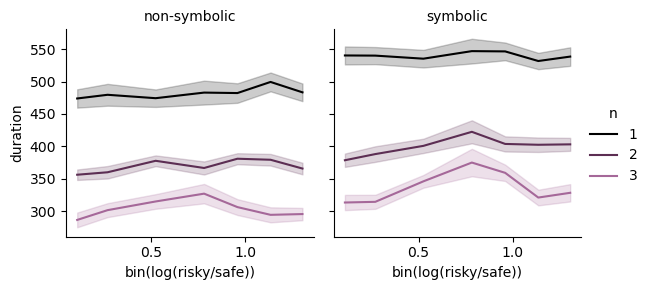

In [ ]:
tmp = fixations.groupby(['subject', 'bin(log(risky/safe))', 'n', 'exptype']).mean()
tmp = tmp[~tmp.isnull().any(1)]

palette = sns.cubehelix_palette(start=.5, rot=0, dark=0, light=.5, n_colors=3, reverse=True)

g = sns.FacetGrid(tmp.query('(n < 4)').reset_index(), col='exptype', hue='n', palette=palette)#, palette='coolwarm')
g.map(sns.lineplot, 'bin(log(risky/safe))', 'duration', errorbar='se')
g.add_legend()
g.set_titles('{col_name}')

tmp = saccades.groupby(['subject', 'bin(log(risky/safe))', 'n', 'exptype']).mean()
palette = sns.cubehelix_palette(start=0, rot=0, dark=0, light=.5, n_colors=3, reverse=True)
g = sns.FacetGrid(tmp.query('(n < 4)').reset_index(), col='exptype', hue='n', palette=palette)#, palette='coolwarm')
g.map(sns.lineplot, 'bin(log(risky/safe))', 'duration', errorbar='se')
g.add_legend()
g.set_titles('{col_name}')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_89038/3683706464.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = last_fixations.groupby(['subject', 'bin(EV_risky)', 'exptype']).mean()
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_89038/3683706464.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  tmp = tmp[~tmp.isnull().any(1)]
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_89038/3683706464.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = last_fixations.groupby(['subject', 'EV_safe',

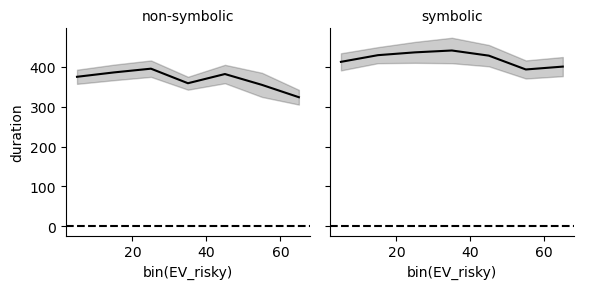

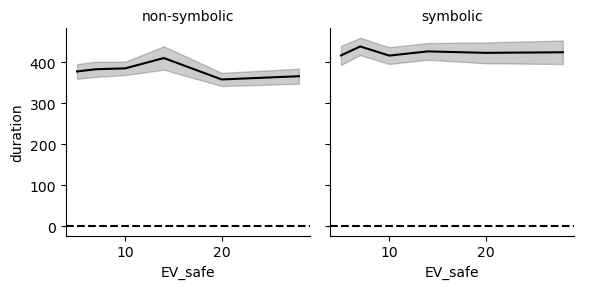

In [ ]:
tmp = last_fixations.groupby(['subject', 'bin(EV_risky)', 'exptype']).mean()
tmp = tmp[~tmp.isnull().any(1)]


g = sns.FacetGrid(tmp.reset_index(), col='exptype')#, palette='coolwarm')
g.map(sns.lineplot, 'bin(EV_risky)', 'duration', errorbar='se', color='k')
g.add_legend()
g.set_titles('{col_name}')
g.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))


tmp = last_fixations.groupby(['subject', 'EV_safe', 'exptype']).mean()
g = sns.FacetGrid(tmp.reset_index(), col='exptype')#, palette='coolwarm')
g.map(sns.lineplot, 'EV_safe', 'duration', errorbar='se', color='k')
g.add_legend()
g.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))
g.set_titles('{col_name}')

# Proportional dwell time

In [ ]:
eyepos = get_all_eyepos_info()

In [ ]:
eyepos = eyepos.join(df)

In [ ]:
eyepos['risky_dwelltime'] = eyepos['left_duration'].where(eyepos['p_left'] == 0.55, eyepos['right_duration'])
eyepos['safe_dwelltime'] = eyepos['left_duration'].where(eyepos['p_left'] == 1.0, eyepos['right_duration'])
eyepos['fixation_duration'] = eyepos['risky_dwelltime'] + eyepos['safe_dwelltime']

eyepos['risky_dwelltime_prop'] = eyepos['risky_dwelltime'] / eyepos['fixation_duration']
eyepos['safe_dwelltime_prop'] = eyepos['risky_dwelltime'] / eyepos['fixation_duration']

In [ ]:
eyepos['EV_risky'] = eyepos['EV_left'].where(eyepos['p_left'] == 0.55, eyepos['EV_right'])
eyepos['EV_safe'] = eyepos['EV_left'].where(eyepos['p_right'] == 0.55, eyepos['EV_right'])

In [ ]:
eyepos['bin(EV_risky)'] = pd.cut(eyepos['EV_risky'], bins=np.arange(0, 120, 10))
eyepos['bin(EV_risky)'].cat.categories = [bin.mid for bin in eyepos['bin(EV_risky)'].cat.categories]

eyepos['bin(EV_safe)'] = pd.cut(eyepos['EV_safe'], bins=np.arange(0, 120, ))
eyepos['bin(EV_safe)'].cat.categories = [bin.mid for bin in eyepos['bin(EV_safe)'].cat.categories]

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83412/4003034342.py:2: FutureWarning: Setting categories in-place is deprecated and will raise in a future version. Use rename_categories instead.
  eyepos['bin(EV_risky)'].cat.categories = [bin.mid for bin in eyepos['bin(EV_risky)'].cat.categories]
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83412/4003034342.py:5: FutureWarning: Setting categories in-place is deprecated and will raise in a future version. Use rename_categories instead.
  eyepos['bin(EV_safe)'].cat.categories = [bin.mid for bin in eyepos['bin(EV_safe)'].cat.categories]


In [ ]:
eyepos

n_saccades first_saccade  last_saccade  \
subject run block trial exptype                                            
01      1   1     1     symbolic           6   left_option   left_option   
                  2     symbolic           3  right_option  right_option   
                  3     symbolic           2   left_option  right_option   
                  4     symbolic           1  right_option  right_option   
                  5     symbolic           1  right_option  right_option   
...                                      ...           ...           ...   
64      5   4     20    symbolic           2  right_option   left_option   
                  21    symbolic           3   left_option   left_option   
                  22    symbolic           3   left_option  right_option   
                  23    symbolic           2   left_option  right_option   
                  24    symbolic           3   left_option   left_option   

                                  left_duration  right_duration  accuracy  \
subject run block trial exptype                                             
01      1   1     1     symbolic         1024.0           462.0       1.0   
                  2     symbolic          204.0           478.0       1.0   
                  3     symbolic          168.0           232.0       1.0   
                  4     symbolic            0.0           282.0       1.0   
                  5     symbolic            0.0           358.0       1.0   
...                                         ...             ...       ...   
64      5   4     20    symbolic          156.0           264.0       1.0   
                  21    symbolic          382.0           196.0       0.0   
                  22    symbolic          872.0           246.0       0.0   
                  23    symbolic          170.0           378.0       0.0   
                  24    symbolic         1050.0           374.0       1.0   

                                     rt  leftRight  pressedKey  n_safe  ...  \
subject run block trial exptype                                         ...   
01      1   1     1     symbolic  1.215        1.0        75.0    14.0  ...   
                  2     symbolic  0.737       -1.0        77.0     5.0  ...   
                  3     symbolic  0.920       -1.0        77.0    14.0  ...   
                  4     symbolic  0.965       -1.0        77.0    10.0  ...   
                  5     symbolic  1.218        1.0        75.0    14.0  ...   
...                                 ...        ...         ...     ...  ...   
64      5   4     20    symbolic  1.046       -1.0        77.0    28.0  ...   
                  21    symbolic  0.840        1.0        75.0    20.0  ...   
                  22    symbolic  0.671        1.0        75.0    10.0  ...   
                  23    symbolic  0.774        1.0        75.0    20.0  ...   
                  24    symbolic  0.874        1.0        75.0    28.0  ...   

                                  EV_right  risky_dwelltime  safe_dwelltime  \
subject run block trial exptype                                               
01      1   1     1     symbolic     14.00           1024.0           462.0   
                  2     symbolic      5.00            204.0           478.0   
                  3     symbolic     14.00            168.0           232.0   
                  4     symbolic     10.00              0.0           282.0   
                  5     symbolic     14.00              0.0           358.0   
...                                    ...              ...             ...   
64      5   4     20    symbolic     43.45            264.0           156.0   
                  21    symbolic     31.35            196.0           382.0   
                  22    symbolic     11.00            246.0           872.0   
                  23    symbolic     22.00            378.0           170.0   
                  24    symbolic     15.95            374.0        